In [1]:
from joblib import dump, load 
import sys
import os
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn, re
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA

In [26]:
def load_aggregate_matrices(direc):
    if os.path.exists(direc):
        spk_vecs = load(os.path.join(direc,'spk_vecs'))
        ph_vecs = load(os.path.join(direc,'ph_vecs'))
        spk_ph_vecs = load(os.path.join(direc,'spk_ph_vecs'))
    return spk_vecs, ph_vecs, spk_ph_vecs


def residual_variance_ratio(vecs, pca):
    '''
    the amount of variance remaining in vecs
    after collapsing each of the principal components of pca
    '''
    vecs_n = np.array(vecs) - np.mean(vecs, axis=0) 
    residual_variance = []
    pca_vecs = PCA(n_components=min(vecs_n.shape[0],vecs_n.shape[1]))
    # print(pca_vecs)
    pca_vecs.fit(vecs)
    residual_variance.append(sum(pca_vecs.explained_variance_))
    for pc in pca.components_:
        proj = np.dot(np.array(vecs_n), pc)
        collapsed_vecs = np.array(vecs_n) - np.dot(proj[:,None],pc[None,])
        pca_collapsed = PCA(n_components=min(vecs_n.shape[0],vecs_n.shape[1]))
        pca_collapsed.fit(collapsed_vecs)
        residual_variance.append(sum(pca_collapsed.explained_variance_))
        vecs_n = collapsed_vecs
    collapsed_variance = np.concatenate([np.array([0,]),np.cumsum(pca.explained_variance_ratio_)])
    return np.array(residual_variance)/residual_variance[0], collapsed_variance

def compute_pca(direc):
    spk_vecs, ph_vecs, spk_ph_vecs = load_aggregate_matrices(direc)
    spk_pca = PCA(n_components=40)
    spk_pca.fit(spk_vecs)
    ph_pca = PCA(n_components=39)
    ph_pca.fit(ph_vecs)
    joint_pca = PCA(n_components=min(100,spk_vecs.shape[1]))
    joint_pca.fit(spk_ph_vecs)
    return spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs

def phone_versus_speaker(direc):
    spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs = compute_pca(direc)
    return residual_variance_ratio(ph_vecs, spk_pca)

def auc(x,y):
    '''
    area under curve 
    '''
    shifted = np.concatenate([[0,],x[:-1]])
    x_increment = x - shifted
    return sum(y*x_increment)

def cumulative_residual_variance(x_vecs, y_vecs):
    '''computes CRV(X/Y)'''
    x_pca = PCA(n_components=len(x_vecs))
    y_pca = PCA(n_components=len(y_vecs))
    x_pca.fit(x_vecs)
    y_pca.fit(y_vecs)
    residual_var, collapsed_var = residual_variance_ratio(x_vecs, y_pca)
    return auc(collapsed_var, residual_var)


def self_crv(vecs):
    n = np.shape(vecs)[0]
    points_pca = PCA(n_components=n)
    points_pca.fit(vecs)
    
    x = np.cumsum(points_pca.explained_variance_ratio_)
    x = np.insert(x,0,0)
    y = 1 - x
    return auc(x,y)


In [3]:
direc = 'aggregated_vectors/logmel'
spk_pca_lm, ph_pca_lm, joint_pca_lm, spk_vecs_lm, ph_vecs_lm, spk_ph_vecs_lm = compute_pca(direc)

In [7]:
direc = 'aggregated_vectors/cpc_init'
spk_pca_init, ph_pca_init, joint_pca_init, spk_vecs_init, ph_vecs_init, spk_ph_vecs_init = compute_pca(direc)

In [8]:
direc = 'aggregated_vectors/cpc_big/layer2'
spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs = compute_pca(direc)

### Comparing similarity plot versus residual variance plot

In [9]:
ph_residual_var, spk_collapsed_var = residual_variance_ratio(ph_vecs, spk_pca)
ph_residual_var_lm, spk_collapsed_var_lm = residual_variance_ratio(ph_vecs_lm, spk_pca_lm)
ph_residual_var_init, spk_collapsed_var_init = residual_variance_ratio(ph_vecs_init, spk_pca_init)

Text(18, 54, '(b)')

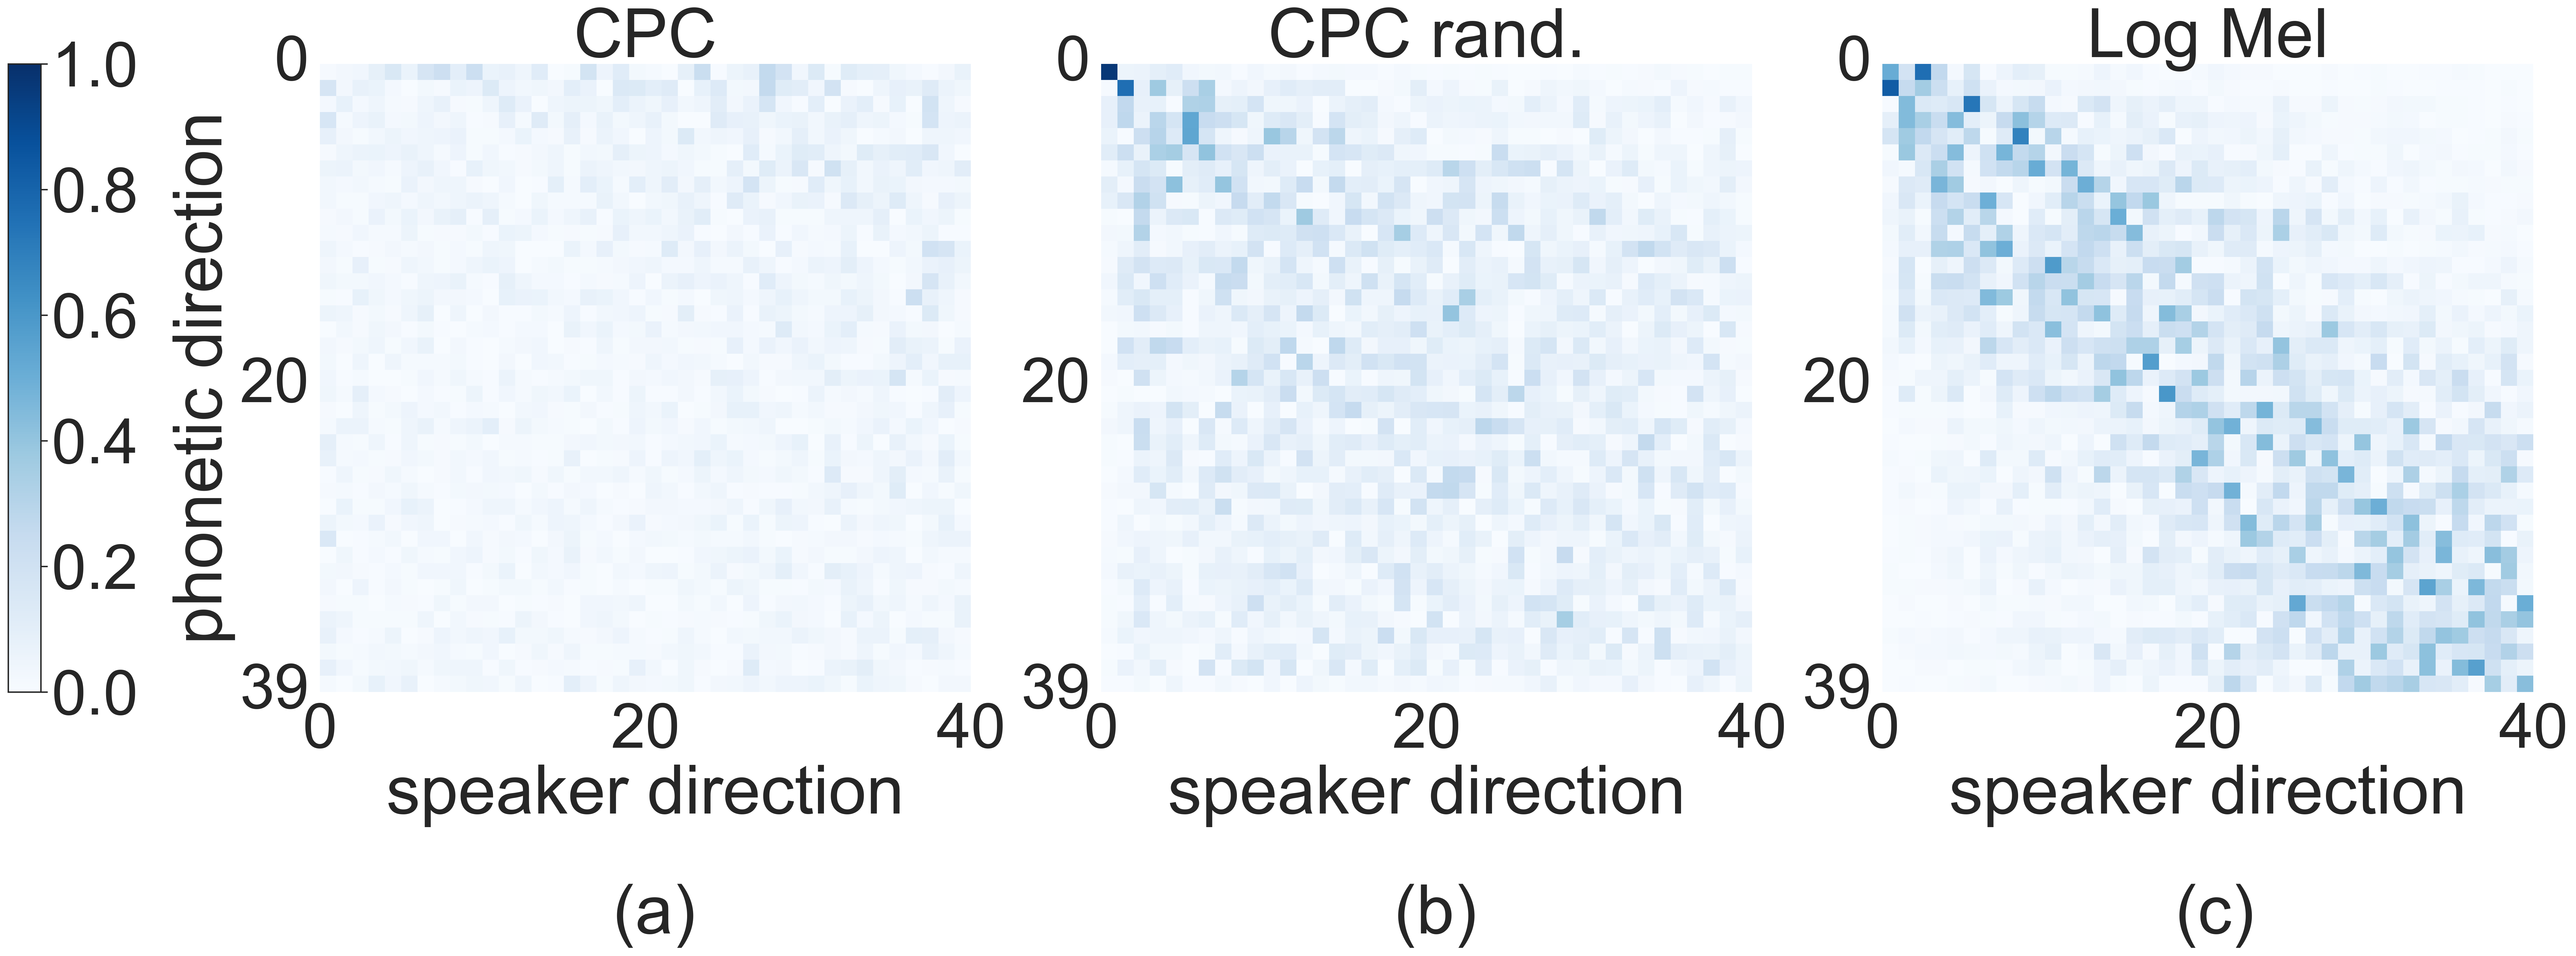

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
sm = plt.cm.ScalarMappable(cmap="Blues")
sns.set_style(style='white')
# plt.autoscale()
sns.set(font_scale=5) 
sns.set_style(style='white')
f, axes = plt.subplots(1,3, figsize=(35,10), dpi=300)#, bbox_inches='tight')
s=sns.heatmap(np.abs(np.dot(ph_pca.components_, spk_pca.components_.transpose())),vmin=0,vmax=1, cmap='Blues',cbar=False, ax=axes[0])
s.set_ylabel('phonetic direction')
s.set_xlabel('speaker direction')
xticks = [0,20,40]
yticks = [0,20,39]
s.set_xticks(xticks)
s.set_yticks(yticks)
s.set_xticklabels(xticks)
s.set_yticklabels(yticks)
s.set_title('CPC')
s.text(18,54,"(a)")
# f.colorbar(sm, ax=axes.flatten(),orientation="vertical",location='left',pad=0)
axins = inset_axes(axes[0],
                    width="5%",  
                    height="100%",
                    loc='center left',
                    borderpad=-5
                   )
f.colorbar(sm, cax=axins, orientation="vertical")

s=sns.heatmap(np.abs(np.dot(ph_pca_lm.components_, spk_pca_lm.components_.transpose())),vmin=0,vmax=1, cmap='Blues',cbar=False, ax=axes[2])
# s.set_ylabel('phone dimensions')
s.set_xticks(xticks)
s.set_yticks(yticks)
s.set_xticklabels(xticks)
s.set_yticklabels(yticks)
# s.set_ylabel('phonetic direction')
s.set_xlabel('speaker direction')
s.set_title('Log Mel')
s.text(18,54,"(c)")

s=sns.heatmap(np.abs(np.dot(ph_pca_init.components_, spk_pca_init.components_.transpose())),vmin=0,vmax=1, cmap='Blues',cbar=False, ax=axes[1])
# s.set_ylabel('phone dimensions')
s.set_xticks(xticks)
s.set_yticks(yticks)
s.set_xticklabels(xticks)
s.set_yticklabels(yticks)
# s.set_ylabel('phonetic direction')
s.set_xlabel('speaker direction')
s.set_title('CPC rand.')
s.text(18,54,"(b)")



Text(0.4, -0.45, '(e)')

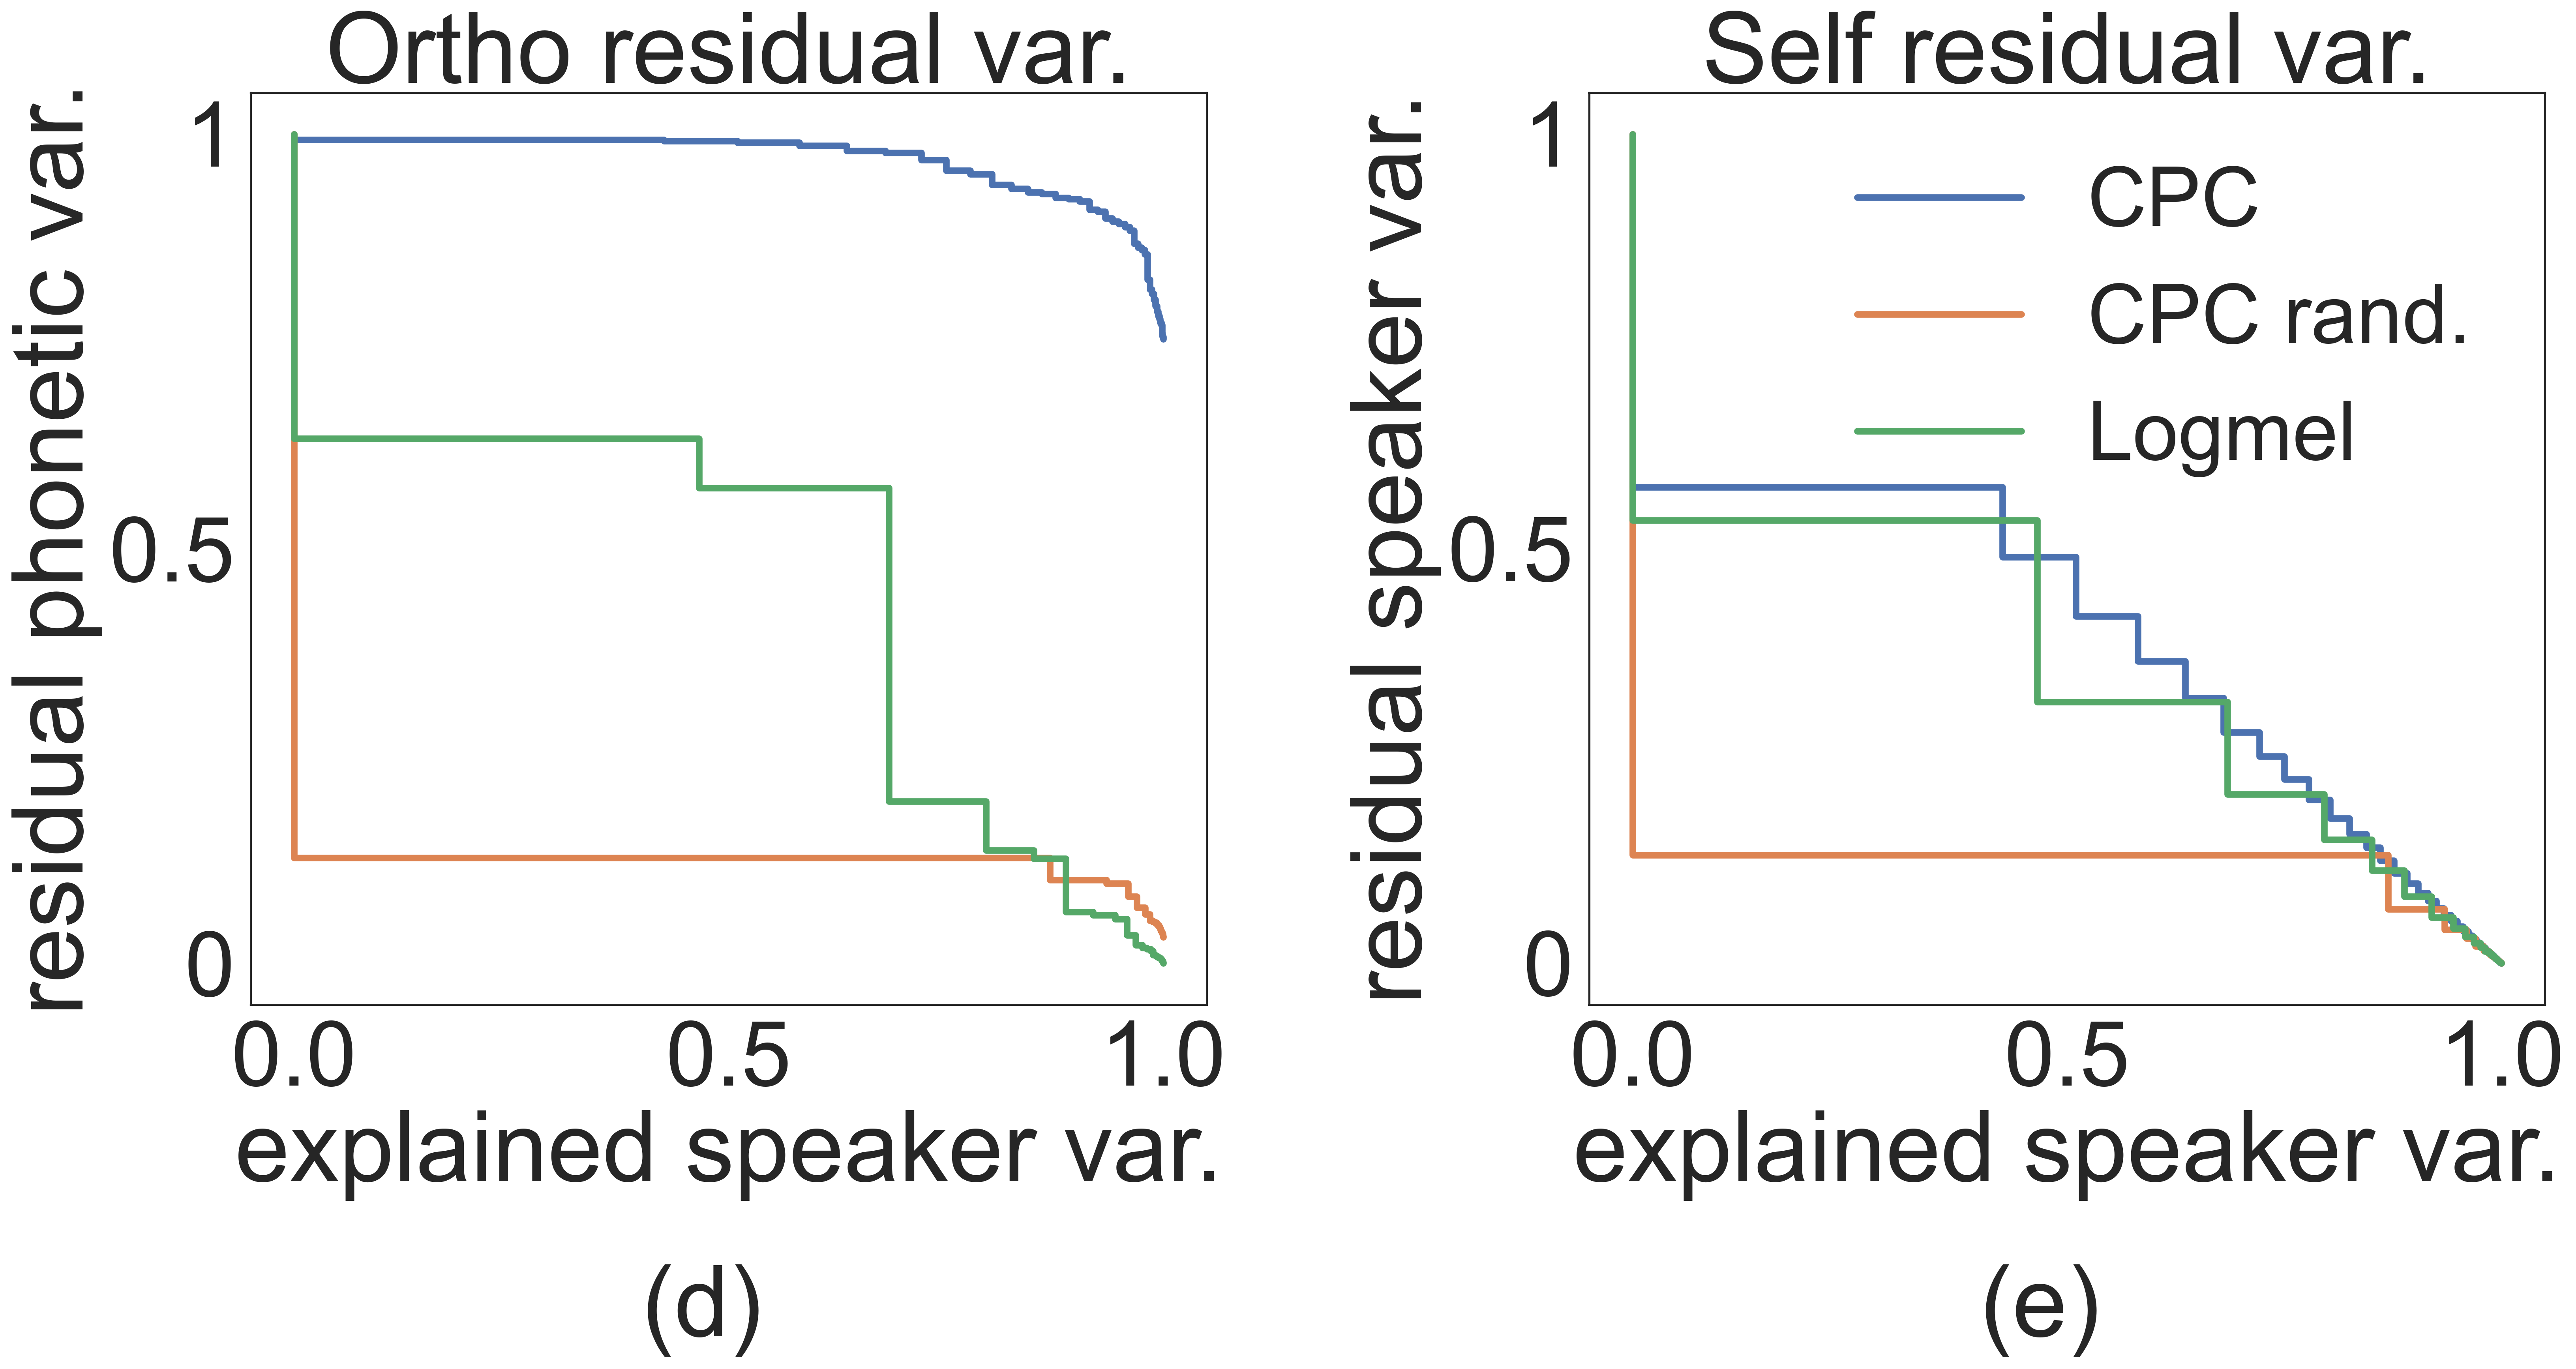

In [11]:
f, axes = plt.subplots(1,2, figsize=(25,10), dpi=300)
sns.set_style(style='white')
ax = axes[0]
ax.step(spk_collapsed_var,ph_residual_var,label='CPC',linewidth=4)
ax.step(spk_collapsed_var_init,ph_residual_var_init,label='CPC init.',linewidth=4)
ax.step(spk_collapsed_var_lm,ph_residual_var_lm,label='Logmel',linewidth=4)

ax.set_xlabel('explained speaker var.')
ax.set_ylabel('residual phonetic var.')
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('Ortho residual var.')
# ax.legend()
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc='upper center',bbox_to_anchor=(1,1.15), ncol=3, markerscale=0, framealpha=0)
ax.text(0.4,-0.45,'(d)')

                   
ax = axes[1]
ax.step(spk_collapsed_var,1-spk_collapsed_var,label='CPC',linewidth=4)
ax.step(spk_collapsed_var_init,1-spk_collapsed_var_init,label='CPC rand.',linewidth=4)
ax.step(spk_collapsed_var_lm,1-spk_collapsed_var_lm,label='Logmel',linewidth=4)

ax.set_xlabel('explained speaker var.')
ax.set_ylabel('residual speaker var.')
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.legend(framealpha=0,fontsize='small')
ax.set_title('Self residual var.')
plt.subplots_adjust(wspace=0.4)
ax.text(0.4,-0.45,'(e)')

# print(auc(ph_residual_var,spk_collapsed_var),auc(ph_residual_var,1-ph_residual_var))
# plt.tight_layout()


In [28]:
cumulative_residual_variance(ph_vecs,spk_vecs)

0.9708718418155846

In [29]:
cumulative_residual_variance(ph_vecs_lm,spk_vecs_lm)

0.45910839123179076

In [30]:
cumulative_residual_variance(ph_vecs_init,spk_vecs_init)

0.12213870510973326

In [21]:
print(self_crv(ph_vecs),self_crv(ph_vecs_lm),self_crv(ph_vecs_init))

0.44560616695020133 0.28482811733424157 0.06555425756317589
